*Last edit by DLao - 2019*





<br>
<br>


![](http://bathvenuefinder.co.uk/web/wp-content/uploads/2016/02/The-Porter-fine-food.jpg)

# Amazon fine food review - Sentiment analysis

The analysis is to study Amazon food review from customers, and try to predict whether a review is positive or negative. The dataset contains **more than 500K reviews** with number of upvotes & total votes to those comments.

## Table of Content

* Data preparation

* Score prediction
  - Logistic regression model on word count
  - Logistic regression model on TFIDF 어떤 단어가 특정 문서 내에서 
얼마나 중요한 것인지를 나타내는 통계적 수치이다
  - Logistic regression model on TFIDF + ngram 모든 단어를 고려하는 것이 아니라 일부 단어만 고려 n은 단어 수 의미 
  
* Upvote prediction
  - Data preview 데이터 미리보기 
  - Resampling due to imbalanced data
  - Logistic regression model on word count
  - Logistic regression model on TFIDF + ngram
  - Study on non-context features
  
* In-depth study on user behaviour *(Edit on 2017/10/18)*
  
<br>
I will keep updating this notebook. Feel free to fork and **Upvote** if you find it useful in some ways!

https://wikidocs.net/22530 의 문서를참고로 코드 해석 

## Data preparation

Let's load some library needed throughout the analysis:

In [0]:
import pandas as pd #데이터 분석 툴 -> 파일을 디비환경으로 바꿈 
import numpy as np #행렬들을 쉽게 해주는 라이브러리 
import matplotlib.pyplot as plt #수식 계산을 해주는 라이브러리 
import seaborn as sns # 메틀랩 기반 시각화 툴 
from sklearn.feature_extraction.text import CountVectorizer #문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 인코딩한 벡터를 만든다. 
#BOW(Bag of words) : 단어들의 출현 빈도(frequency)에만 집중하는 텍스트 데이터의 수치화 표현 방법
from sklearn.feature_extraction.text import TfidfVectorizer
#CountVectorizer와 비슷하지만 TF-IDF 방식으로 단어의 가중치를 조정한 BOW 벡터를 만든다.
from sklearn.linear_model import LogisticRegression #로지스틱 회기를 이용 한다. 
from sklearn.model_selection import train_test_split #교차 검증 
from sklearn.dummy import DummyClassifier #더미 분류기 실제아닌 더미값 
from string import punctuation #뭔가 기준으로 지우기 위해 만들어짐 
from sklearn import svm #서포트 백터 머신
#NLTK(Natural Language Toolkit) 패키지는 교육용으로 개발된 자연어 처리 및 문서 분석용
#말뭉치(corpus)는 자연어 분석 작업을 위해 만든 샘플 문서 집합
from nltk.corpus import stopwords #I, my, me, over, 조사, 접미사 같은 단어들은 분석에 기여도가 낮다 -> 이걸을 제거하는 것인 stopword (불용어) 
from nltk.stem import WordNetLemmatizer #원형 복원(lemmatizing)은 같은 의미를 가지는 여러 단어를 사전형으로 통일하는 작업
import nltk
from nltk import ngrams #모든 단어를 고려하는 것이 아니라 일부 단어만 고려 n은 단어 수 의미
from itertools import chain #반복되는 작업을 쉽게 하는 것중 리스트를 하나로 묶는다.
from wordcloud import WordCloud #구름 형태로 나타냄 


Now we load in the dataset and add some columns for upvote metrics: 데이터 로드

In [9]:
odf = pd.read_csv('./Reviews.csv') #판다스의 csv(엑셀)파일을 읽어드림 odf로 
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1) 
#helpful이란 열을 추가 where은 조건  HelpfulnessDenominator 0보다 크고 Numerator(본사람 중 좋아요 누른사람 수) / Denominator 댓글을 본사람
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
#Upvote열 추가 helpful의 퍼센트에 따라 -1이면 비어있다. 0.2는 0-20 %...이렇게 
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1.0, 'How helpful users find among user scores')

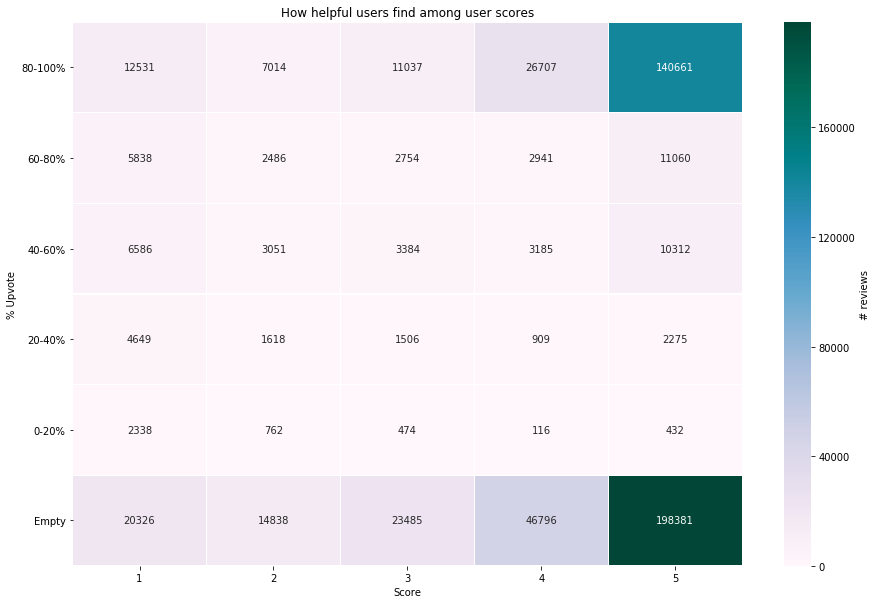

In [19]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1) #get_level_values값을 가지고 와서 열로 만듬 
fig = plt.figure(figsize=(15,10)) #15, 10 만큼 그려라

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'PuBuGn', linewidths=.10, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
#heatmap 그림을 그리는 함수 , cmap 색상
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Key message from above:
* Reviews are skewed towards positive 긍정적인 리뷰
* More than half of the reviews are with zero vote 반이상이 0인 리뷰 
* Many people agree with score 5 reviews 5점은 신뢰성이 있다.

Then we get rid of score 3 reviews (neutral), and separate the remaining reviews into binary class (1 = positive, 0 = negative):
5개의 분류에서 3을 제외하고 -> 
두개로 나눈다. 1 긍정 0 부정 

In [0]:
df = odf[odf['Score'] != 3] #SCORE 3 제외 
X = df['Text'] #텍스트 값을 x값에 집어넣음 
y_dict = {1:0, 2:0, 4:1, 5:1} #1 ,2 는 부정 0으로, 4 ,5 는 긍정 1로 dick으로 바꿈 
y = df['Score'].map(y_dict) #score을 y_dict으로 매핑 (1,2 부정, 4,5 긍정)

## Score prediction
### Logistic regression model on word count 로지스틱 회귀 (워드 카운트 사용)

In [20]:
c = CountVectorizer(stop_words = 'english')
#CountVectorizer -> 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 인코딩한 벡터를 만든다. 
#stop_words -> 영어의 불필요한 단어 제외 (i, am , .... ) 

def text_fit(X, y, model,clf_model,coef_show=1): 
  # text_fit함수 인자값 (X=텍스트 ,y=0 또는 1, clf_model=분류 모델, coef_show 추정된 가중치 벡터를 보여줌 
    
    X_c = model.fit_transform(X) #X(텍스트)를 모델에 맞게 변형
    print('# features: {}'.format(X_c.shape[1])) #전체 단어 수 (stop_word 제외)
    
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0) #train_test_split는 import한것 (교차검증)을 하려고 나눈것  
    #train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify) 랜덤 30퍼는 Test 70퍼 Train
    #(2) Return -> X_train, X_test, Y_train, Y_test : arrays에 데이터와 레이블을 둘 다 넣었을 경우의 반환이며, 데이터와 레이블의 순서쌍은 유지된다.
    #자세한 내용 http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872&from=search&redirect=Log&widgetTypeCall=true&directAccess=false
    
    print('# train records: {}'.format(X_train.shape[0])) #학습 데이터 수 
    
    print('# test records: {}'.format(X_test.shape[0])) #테스트 데이터 수  
    clf = clf_model.fit(X_train, y_train) #클래스 모델에 맞게 x, y train 한다.  -> 여기서는 
    acc = clf.score(X_test, y_test) #정확도 측정 Test데이터를 사용 
    print ('Model Accuracy: {}'.format(acc)) # 정확도 
    
    if coef_show == 1: #coef_show 초기값이 1임으로 무조건 돈다.
        w = model.get_feature_names() #열의 이름 여기선 word의미 
        coef = clf.coef_.tolist()[0] #백터 어쩌구 ... ㅠ 그냥 비율정도? 
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])#정렬 Coefficient를 기준으로 
        print('')
        print('-Top 20 positive- 긍정적인 단어 20개')
        print(coeff_df.head(20).to_string(index=False)) #20개 위것 보여주세요ㅕ 
        print('')
        print('-Top 20 negative- 부정적인 단어 20개')        
        print(coeff_df.tail(20).to_string(index=False)) #20개 아래것 보여주세요ㅕ 
    
    
text_fit(X, y, c, LogisticRegression()) #워드 카운트 사용하여 테스트 

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Accuracy: 0.9387238121320005

-Top 20 positive-
          Word  Coefficient
    pleasantly     3.329288
 emeraldforest     3.207255
       chedder     3.035348
       easiest     2.565034
       solving     2.457885
       blowout     2.453533
      heartier     2.374949
     addicting     2.370846
    unwrapping     2.303152
         herrs     2.302714
        skewed     2.298513
      drawback     2.292790
        hooked     2.290675
        hahaha     2.263947
      downside     2.249952
    correction     2.242844
         whisk     2.198567
        ration     2.192384
        bertie     2.191823
    dishwasher     2.170732

-Top 20 negative-
          Word  Coefficient
    unfinished    -2.466368
      tastless    -2.492724
       weakest    -2.602855
     overrated    -2.615757
     cancelled    -2.693047
   unappealing    -2.731093
       furious    -2.745249
    oversalted    -2.753954
     deceptive    -2.821908
 disappointing    -2.822680
   undrinkable    -2.826428
   

Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficients are not meaningful, e.g. 280mg. 정확도 93.9라지만 의미가 다 있지 않다. 

Let's also look at the base line accuracy (predicting with majority class, in this case positive class): 기준선 정확도 (대다수 클래스로 예측,이 경우 긍정적 인 클래스)를 살펴 보겠습니다

In [21]:
text_fit(X, y, c, DummyClassifier(),0) #더미를 사용하여 결과를 나타냄 // 기존은 로지스틱 회기

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.7355500783544053


### Logistic regression model on TFIDF TFIDF를 사용 하여 분석

In [22]:
tfidf = TfidfVectorizer(stop_words = 'english') #tfidf를 이용하여 위의 함수를 쓰기위해 만듬 
text_fit(X, y, tfidf, LogisticRegression()) #c의 값에 tfidf를 이용 //기존 워드카운터 모델 


# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9346995907313584

-Top 20 positive-
       Word  Coefficient
      great    13.713289
  delicious    12.149677
       best    12.012551
    perfect    10.605830
  excellent     9.859239
      loves     9.574394
     highly     9.034593
       love     8.363185
  wonderful     7.964786
    amazing     7.796027
    awesome     7.632406
       good     7.338175
 pleasantly     7.248380
       nice     7.180714
     hooked     7.019343
      yummy     6.953029
   favorite     6.936164
    pleased     6.933233
     smooth     6.884505
  fantastic     6.719434

-Top 20 negative-
           Word  Coefficient
          waste    -5.623804
           poor    -5.718327
    undrinkable    -5.725048
           yuck    -6.009178
          stale    -6.145355
          worse    -6.278523
          bland    -6.324403
     disgusting    -6.554619
           weak    -6.565077
         return    -6.685168
          threw    -6.734109
      tasteless    -6.835248
  unfortunately    -7.436

# Accurancy is roughly the same - 93.5%. However we notice that the significant words make much more sense now, with higher coefficient magnitude as well!
정확도는 똑같지만 더 중요한 단어 가 더 의미 있다. 

### Logistic regression model on TFIDF + ngram

In [23]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english') #ngram_range = (min_n, max_n) 의미 
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 래퍼런스 문서 
text_fit(X, y, tfidf_n, LogisticRegression()) # tfidf_n -> n은 단어를 조합하는 갯수를 의미 
#c의 값에 tfidf_n 이용 //기존 워드카운터 모델 

# features: 3933179
# train records: 394360
# test records: 131454


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9454714196601093

-Top 20 positive-
             Word  Coefficient
            great    21.054577
             best    17.831601
        delicious    17.012872
          perfect    14.624623
            loves    13.611160
             love    13.272387
        excellent    13.144334
             good    11.418326
        wonderful    11.321080
             nice    10.811514
         favorite    10.594919
          amazing     9.691426
          awesome     9.371318
             easy     9.143947
          pleased     8.947594
            happy     8.906614
           smooth     8.715677
            yummy     8.592553
           highly     8.466686
 highly recommend     8.423070

-Top 20 negative-
           Word  Coefficient
          maybe    -7.807009
         hoping    -8.129029
      tasteless    -8.250228
          money    -8.319548
          worse    -8.353005
        thought    -8.564717
     disgusting    -8.764723
          bland    -9.145294
          threw

Adding ngram parameter, we are able to understand phrase like "not good". Therefore the accuracy goes up a bit to 94.5%. We can see "highly recommend" is on 20th place of positive words


> ngram 파라미터를 더하면, 우리는 "좋지 않다"와 같은 구절을 이해할 수 있다. 따라서 정확도는 94.5%로 약간 상승한다. 우리는 "매우 추천"이 긍정적인 단어의 20위임을 알 수 있다.



## Upvote prediction
### Data preview

This study is to see whether there is pattern found for unpopular (downvote) comments by users (might be used to boost sales).
We will be focusing on score 5 reviews, and get rid of comments with neutral votes:
인기 없는(다운ote) 코멘트에 대한 패턴이 있는지 알아보기 위한 것이다 5개로 나눔 

In [24]:
df = df[df['Score'] == 5] #5분류 
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
# 40% 까지 0(부정 ) 60%부터 1 (긍정)
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts()) #긍정수 . 부정수 나타냄 

Class distribution:
1    151721
0      2707
Name: % Upvote, dtype: int64


The target class is highly skewed to positive (upvotes). Let's resample the data to get balanced data:
너무 좋게 기울어진 데이터 벨런스를 잡게 다시 resample

In [25]:
df_s = pd.DataFrame(data = [X,y]).T #E데이터를 받아옴 

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.ix[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


### Logistic regression model on word count

In [0]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

The words look no sense at all, and the coefficients are very small.

### Logistic regression model on TFIDF + ngram

In [0]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

Similar to count metric, the accuracy isn't very high and words are not meaningful.

### Study on non-context features

[링크 텍스트](https://)

Let's look at some examples of upvote and downvote comments: 5개의 좋은 코맨트 안좋은 코맨트를 보자


In [26]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20]) #UPVOTE가 0인거 (부정적인것 )iloc는 숫자를 의미 0부타 100까지 20단위씩 
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20]) #1인것 긍정적인것

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
5659      I think these are a bit boring (I like my cook...
236724    If you think your only onion dip choice is the...
493364    I want to tell you ---- from the get-go ---- t...
445390    Somewhere along the line I switched from groun...
281315    Torani Salted Caramel Syrup is so delicious. I...
Name: Text, dtype: object


Time to extract some possible features: 좋은 특징을 뽑아보자

In [27]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split())) #람다 펑션을 이용하여 SPLIT한후 갯수를 워드카운트에 넣는다.
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper())) #대문자 수 
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?')) #?수 
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!')) #lexclamation_mark 느낌표 개수
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation)) #구두점 수

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)
#groupby는 Upvote로 묶는다 (0과 1로 나눔 ) word_count 평균 .... 이렇게 결과갑 보면 알수 있다.

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]#'% Upvote', 'Text이것만 빼서 x_num으로 
y_num = under_sample_data['% Upvote']


% Upvote                  0          1
word_count        83.927226  87.163650
capital_count     19.252678  14.403399
question_mark      0.180273   0.084595
exclamation_mark   0.906169   0.972663
punctuation       22.482822  19.505356


Now we train the model to predict:
이제 새로운 모델로 예측

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0) 
#교차검증을 알아서 해주는 함수에 넣어서 분리 X_num은 X축 갯수 y_num Y축 갯수

clf_lr = LogisticRegression().fit(X_train, y_train) #로지스틱 회기 
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train) #SVM으로 예측 
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Logistic Regression accuracy: 0.5915805022156573
SVM accuracy: 0.672082717872969


Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.
정확도가 낮음 

## In-depth study on user behaviour

---



This analysis will be carried out to focus on one specific user, on what he / she likes in terms of fine food, based on the reviews he / she had given in the past. This can be expanded to all users later on. 한 유저를 지정하여 이전의 리뷰를 통해 그가 좋아할지 판단

First let's look at how many reviews each user gave in the past:
먼저 과거에 각 사용자가 얼마나 많은 리뷰를 했는지 살펴보자.

In [30]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']}) #UserId', 'ProfileName이것을 행 Score':['count', 'mean'] 스코어 카운트와 평균이 열
df_user.columns = df_user.columns.get_level_values(1) #Index(['count', 'mean'], dtype='object') 이런 갑이 들어간다. 열의 이름 
df_user.columns = ['Score count', 'Score mean'] #열의이름을 바꾼다.'count -> Score count', mean -> 'Score mean'
df_user = df_user.sort_values(by = 'Score count', ascending = False) #score count로 정렬 ascending = False -> 내림차순으로 
print(df_user.head(10)) #열개 보여달라


Index(['count', 'mean'], dtype='object')
                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:
CFH의 리뷰를 분석해보자

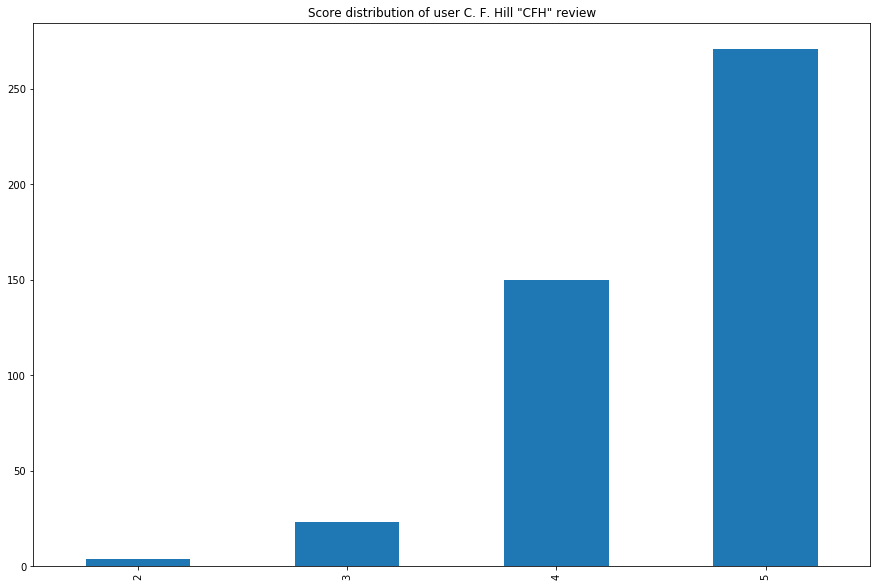

In [49]:
def plot_user(UserId): #plot_user함수 지정 인자값 (유저 아이디 )
    df_1user = odf[odf['UserId'] == UserId]['Score'] #점수를 기준으로 
    df_1user_plot = df_1user.value_counts(sort=False) #점수의 분포를 알려줌 (갯수)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))
    #그림 그리기

plot_user('A3OXHLG6DIBRW8') #A3OXHLG6DIBRW8라는 유저아이디

It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's dig into that: 너무 편향된 값 (좋게)그러므로 다른사람으로 정하자

In [32]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head()) #3.5에사 2.5사이의 스코어를 한 사람 구함

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


A. Bennett seems a good target: 좋은사람 찾음

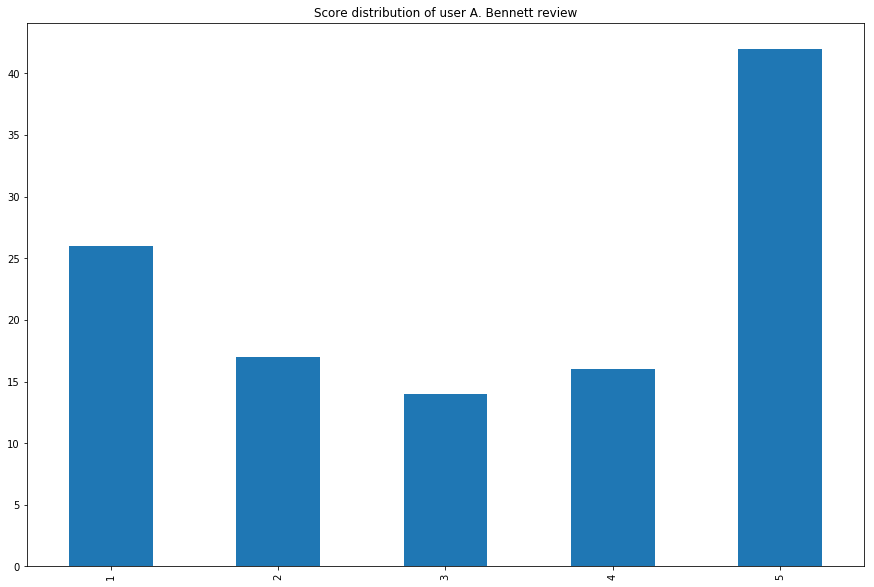

In [33]:
plot_user('A2M9D9BDHONV3Y') #A2M9D9BDHONV3Y이 사람을 기준으로 그림

He seems like a better analysis target! Now let's dig deep into his reviews: 그가 더 좋은 타겟이다 (바꾼사람) 그러므로 더 깊게 분석 ㄱ 

In [40]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
def get_token_ngram(score, benchmark, userid='all'): #토큰을 n그램으로 분석 

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer() #lemmatizer 여러 같은 단어를 사전적으로 통합 
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text] #동사만 
    bigrams = ngrams(total_text,2) #n=2 
    trigrams = ngrams(total_text, 3)#n=3

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text) #단어 사용 빈도 
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])
    #백분위로 나타내고 ?????????

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
score 1 reviews most popular 2-gram / 3-gram:
   Count  Occur %                   Phrase
0   31.0  119.23%               (..., ...)
1   17.0   65.38%          (..., ..., ...)
2   11.0   42.31%             (never, buy)
3    9.0   34.62%           (buy, product)
4    8.0   30.77%  (monosodium, glutamate)
5    8.0   30.77%    (never, buy, product)
6    7.0   26.92%          (picture, look)
7    7.0   26.92%         (dry, tasteless)
8    7.0   26.92%            (decide, try)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %                Phrase
0     8.0  47.06%  (sauce, ruin, whole)
1     8.0  47.06%         (ruin, whole)
2     8.0  47

Seems like A. Bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). He likes using the phrase "..." a lot as well. Sample size is very small though.
좋은 데이터이지만 표본이 너무 작다
Let's look at full picture now instead of just one user: 
한명보다 여려명을 보자

In [41]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5536.0  10.59%   (taste, like)
1  2316.0   4.43%  (waste, money)
2  2175.0   4.16%    (could, n't)
3  2111.0   4.04%     (n't, even)
4  1809.0   3.46%     (n't, know)
5  1794.0   3.43%    (would, n't)
6  1644.0   3.15%      (n't, buy)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3161.0  10.62%   (taste, like)
1  1362.0   4.58%     (n't, like)
2  1304.0   4.38%    (would, n't)
3  1086.0   3.65%  (think, would)
4  1064.0   3.57%      (n't, buy)
5  1010.0   3.39%     (n't, know)
6   996.0   3.35%    (n't, taste)
7   945.0   3.17%    (could, n't)
8   910.0   3.06%   (taste, good)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3237.0   7.59%   (taste, like)
1  1632.0   3.83%    (would, n't)
2  1612.0   3.78%     (n't, like)
3  1551.0   3.64%   (taste, good)
4  1463.0   3.43%   (href=, http)
5  1406.0    3.3%     (n't, know)
6  1295.0   

Funny that people are more likely to attach HTML links (href=) for more positive reviews (3 and 4).
<br>
Other than that, not much useful discoveries except positive / negative tones, since people are very different in texting style. 
<br>
Maybe we should focus on popular single **adjective** word people used for different score. First we modify the function a bit for easier implementation:
<br>사람들이 좀 더 긍정적인 리뷰(3, 4)를 위해 HTML 링크(href=)를 첨부할 가능성이 높다는 것은 웃기는 일이다. 
그 외에는 사람들이 문자 문자에 있어서 매우 다르기 때문에 긍정적이고 부정적인 음조를 제외하고는 그다지 유용한 발견은 아니다. 
아마도 우리는 사람들이 다른 점수에 사용했던 인기 있는 단일 형용사에 초점을 맞춰야 할 것이다. 먼저 보다 쉬운 구현을 위해 기능을 약간 수정:





In [46]:
nltk.download('averaged_perceptron_tagger')
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer() #lemmatizer 여러개의 같은 단어를 사전적으로 통합 
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text] #a는 형용사로 뽑아낸다 
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']#형용사로 뽑아낸다
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Let's look at user A. Bennett again:

In [47]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y') #25퍼센트 이상인것만 
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True) #Series는 행령을 뜻함 i는 행을 의미 index는 Phrase', 'Count', 'Occur %로
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
   Count Occur %     Phrase
0   13.0   50.0%        dry
1   12.0  46.15%     cheese
2   10.0  38.46%        bad
3   10.0  38.46%     little
4    8.0  30.77%      tasty
5    8.0  30.77%  delicious
6    8.0  30.77%       hard
7    8.0  30.77%  expensive
8    7.0  26.92%       poor
9    7.0  26.92%      bread
score 2 reviews most popular adjectives word:
   Count Occur %      Phrase
0   10.0  58.82%       whole
1    8.0  47.06%      cheese
2    6.0  35.29%   delicious
3    6.0  35.29%       wrong
4    6.0  35.29%       awful
5    5.0  29.41%       .give
6    5.0  29.41%  particular
7    5.0  29.41%        good
score 3 reviews most popular adjectives word:
   Count Occur %        Phrase
0    9.0  64.29%         whole
1    5.0  35.71%          high
2    4.0  28.57%         great
3    4.0  28.57%         first
4    4.0  28.57%  disappointed
5    4.0  28.57%          good
score 4 reviews most popular adjectives word:
   Count Occur %     Phrase
0 

Obviously much more useful information here, e.g. A. Bennett hates food that are too dry and expensive
<br>
Let's also look at big picture:

In [48]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Count Occur %        Phrase
0   16185.0  30.97%          good
1   10777.0  20.62%           bad
2    4977.0   9.52%         great
3    4844.0   9.27%          much
4    4786.0   9.16%        little
5    4774.0   9.13%           old
6    4198.0   8.03%         first
7    3956.0   7.57%           new
8    3789.0   7.25%     different
9    3717.0   7.11%          many
10   3537.0   6.77%         small
11   3296.0   6.31%          real
12   3000.0   5.74%  disappointed
13   2884.0   5.52%          sure
14   2831.0   5.42%          free
15   2823.0    5.4%          diet
16   2761.0   5.28%          high
17   2658.0   5.09%          last
score 2 reviews most popular adjectives word:
      Count Occur %        Phrase
0   13519.0  45.41%          good
1    4251.0  14.28%          much
2    4169.0   14.0%           bad
3    3909.0  13.13%         great
4    3691.0   12.4%        little
5    2847.0   9.56%         small
6    2323.0    7.8%     

Appreciate any comments!

Hope it is a fun read!